<a href="https://colab.research.google.com/github/ML-brooowss/ML/blob/main/CF_w.knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split

# Recommender Systems
The goal of this section is to hypertune Colaborative filtering using knn-neighbours.

## Task 1: Exploring the Dataset with Implicit Feedback




In [ ]:
# Load the datasets
interactions = pd.read_csv('https://raw.githubusercontent.com/linneverh/MachineLearning/main/interactions_train.csv')
items = pd.read_csv("https://raw.githubusercontent.com/linneverh/MachineLearning/main/items.csv")

# Display the first rows of each dataset
display(interactions.head())
display(items.head())

,u,i,t
0,4456,8581,1.687541e+09
1,142,1964,1.679585e+09
2,362,3705,1.706872e+09
3,1809,11317,1.673533e+09
4,4384,1323,1.681402e+09


,Title,Author,ISBN Valid,Publisher,Subjects,i
0,Classification décimale universelle : édition ...,NaN,9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,0
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,1
2,Histoire de vie et recherche biographique : pe...,NaN,2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2
3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3
4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4


In [ ]:
# Rename columns in the interactions DataFrame
interactions = interactions.rename(columns={'u': 'user_id', 'i': 'book_id', 't': 'timestamp'})
items=items.rename(columns={'i':'book_id'})
# Display the first rows of the updated interactions DataFrame
display(interactions.head())
display(items.head())


,user_id,book_id,timestamp
0,4456,8581,1.687541e+09
1,142,1964,1.679585e+09
2,362,3705,1.706872e+09
3,1809,11317,1.673533e+09
4,4384,1323,1.681402e+09


,Title,Author,ISBN Valid,Publisher,Subjects,book_id
0,Classification décimale universelle : édition ...,NaN,9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,0
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,1
2,Histoire de vie et recherche biographique : pe...,NaN,2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2
3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3
4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4



##Task 2: Split the Data into Training and Test Sets

In [ ]:
# let's first sort the interactions by user and time stamp
interactions = interactions.sort_values(["user_id", "timestamp"])
interactions.head(10)

,user_id,book_id,timestamp
21035,0,0,1.680191e+09
28842,0,1,1.680783e+09
3958,0,2,1.680801e+09
29592,0,3,1.683715e+09
6371,0,3,1.683715e+09
41220,0,4,1.686569e+09
12217,0,5,1.687014e+09
19703,0,6,1.687014e+09
64522,0,7,1.687014e+09
29380,0,8,1.687260e+09


In [ ]:
interactions["pct_rank"] = interactions.groupby("user_id")["timestamp"].rank(pct=True, method='dense')
interactions.reset_index(inplace=True, drop=True)
interactions.head(10)

,user_id,book_id,timestamp,pct_rank
0,0,0,1.680191e+09,0.04
1,0,1,1.680783e+09,0.08
2,0,2,1.680801e+09,0.12
3,0,3,1.683715e+09,0.16
4,0,3,1.683715e+09,0.20
5,0,4,1.686569e+09,0.24
6,0,5,1.687014e+09,0.28
7,0,6,1.687014e+09,0.32
8,0,7,1.687014e+09,0.36
9,0,8,1.687260e+09,0.40


In [ ]:
train_data = interactions[interactions["pct_rank"] < 0.8]
test_data = interactions[interactions["pct_rank"] >= 0.8]

In [ ]:
print("Training set size:", train_data.shape[0])
print("Testing set size:", test_data.shape[0])

Training set size: 65419
Testing set size: 21628


## Task 3: Creating User-Item Matrices for Implicit Feedback


In [ ]:
n_users = interactions["user_id"].nunique()
n_items = items["book_id"].nunique()

In [ ]:
print('number of users =', n_users, '| number of movies =', n_items)

number of users = 7838 | number of movies = 15291


#### Step 1: Define the Function to Create the Data Matrix


In [ ]:
# Define a function to create the data matrix
def create_data_matrix(data, n_users, n_items):
    """
    This function returns a numpy matrix with shape (n_users, n_items).
    Each entry is a binary value indicating positive interaction.
    """
    data_matrix = np.zeros((n_users, n_items))
    data_matrix[data["user_id"].values, data["book_id"].values] = 1
    return data_matrix

#### Step 2: Create the Training and Testing Matrices

In [ ]:
# Create the training and testing matrices
train_data_matrix = create_data_matrix(train_data, n_users, n_items)
test_data_matrix = create_data_matrix(test_data, n_users, n_items)

# Display the matrices to understand their structure
print('train_data_matrix')
print(train_data_matrix)
print("number of non-zero values: ", np.sum(train_data_matrix))
print('test_data_matrix')
print(test_data_matrix)
print("number of non-zero values: ", np.sum(test_data_matrix))


train_data_matrix
[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
number of non-zero values:  49689.0
test_data_matrix
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
number of non-zero values:  19409.0


In [ ]:
#give the dimensions of matrices

print("Train data matrix dimensions:", train_data_matrix.shape)
print("Test data matrix dimensions:", test_data_matrix.shape)

Train data matrix dimensions: (7838, 15291)
Test data matrix dimensions: (7838, 15291)


## Step 3: KNN model


### Basic definitions

In [ ]:
# Recommendation frame generation
def create_recommendation_table(user_predictions, top_n=10, separator=" "):
    """
    Creates a table of top-N recommendations for each user.

    Args:
        user_predictions (numpy.ndarray): Rows = users, columns = items. Predicted scores.
        top_n (int): Number of top recommendations per user.
        separator (str): Delimiter to join recommended book IDs.

    Returns:
        pandas.DataFrame: Columns = ['user_id', 'recommendation'].
    """
    recommendations = []
    num_users = user_predictions.shape[0]

    for user_id in range(num_users):
        top_items = np.argsort(user_predictions[user_id, :])[-top_n:][::-1]
        recommendations.append({
            'user_id': user_id,
            'recommendation': separator.join(map(str, top_items))
        })

    return pd.DataFrame(recommendations)

In [ ]:
# Def for the precision_recall_at_k function
def precision_recall_at_k(prediction, ground_truth, k=10):
    """
    Calculates Precision@K and Recall@K for top-K recommendations.
    Parameters:
        prediction (numpy array): The predicted interaction matrix with scores.
        ground_truth (numpy array): The ground truth interaction matrix (binary).
        k (int): Number of top recommendations to consider.
    Returns:
        precision_at_k (float): The average precision@K over all users.
        recall_at_k (float): The average recall@K over all users.
    """
    num_users = prediction.shape[0]
    precision_at_k, recall_at_k = 0, 0

    for user in range(num_users):
        # TODO: Get the indices of the top-K items for the user based on predicted scores
        top_k_items = np.argsort(prediction[user, :])[-k:]

        # TODO: Calculate the number of relevant items in the top-K items for the user
        relevant_items_in_top_k = np.isin(top_k_items, np.where(ground_truth[user, :] == 1)[0]).sum()

        # TODO: Calculate the total number of relevant items for the user
        total_relevant_items = ground_truth[user, :].sum()

        # Precision@K and Recall@K for this user
        precision_at_k += relevant_items_in_top_k / k
        recall_at_k += relevant_items_in_top_k / total_relevant_items if total_relevant_items > 0 else 0

    # Average Precision@K and Recall@K over all users
    precision_at_k /= num_users
    recall_at_k /= num_users

    return precision_at_k, recall_at_k

In [ ]:
# Create random splits def.
def random_split_per_user(interactions_df, test_size=0.2):
    train_list = []
    test_list = []
    for user_id, user_df in interactions_df.groupby('user_id'):
        train_df, test_df = train_test_split(user_df, test_size=test_size)
        train_list.append(train_df)
        test_list.append(test_df)
    return pd.concat(train_list), pd.concat(test_list)

###CF Item-based w. KNN

In [ ]:
# Efficient item-based KNN prediction
def item_based_knn_predict_fast(train_matrix, k):
    n_users, n_items = train_matrix.shape
    predictions = np.zeros((n_users, n_items))

    # Fit KNN on items (transpose to shape: n_items × n_users)
    knn = NearestNeighbors(n_neighbors=k+1, metric='cosine', algorithm='brute')
    knn.fit(train_matrix.T)

    # Find all neighbors for each item
    distances, indices = knn.kneighbors(train_matrix.T)

    # Convert distances to similarities
    sim_matrix = 1 - distances[:, 1:]  # shape: (n_items, k)
    sim_matrix_sum = sim_matrix.sum(axis=1, keepdims=True) + 1e-9
    sim_weights = sim_matrix / sim_matrix_sum

    # Vectorized prediction across users
    for item_idx in range(n_items):
        top_k_items = indices[item_idx, 1:]  # drop the item itself
        weights = sim_weights[item_idx]      # similarity weights (length k)
        # Predict: dot product of each user’s interactions with similar items
        predictions[:, item_idx] = train_matrix[:, top_k_items] @ weights

    return predictions

# Try different k values
k_values = list(range(10, 100, 10))
precision_scores = []

for k in k_values:
    print(f"Evaluating k = {k}")
    preds = item_based_knn_predict_fast(train_data_matrix, k)
    precision, _ = precision_recall_at_k(preds, test_data_matrix, k=10)
    precision_scores.append(precision)

# Find best k
best_index = np.argmax(precision_scores)
best_k = k_values[best_index]
best_score = precision_scores[best_index]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(k_values, precision_scores, '-o', label='Precision@10')
plt.axvline(best_k, linestyle='--', color='red', label=f'Best k = {best_k}')
plt.title("Item-Based KNN — Precision@10 vs k")
plt.xlabel("k (Number of Nearest Items)")
plt.ylabel("Precision@10")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Best k = {best_k} with Precision@10 = {best_score:.4f}")



In [ ]:
# With cross-validation
# # Cross-validation function
# def evaluate_knn_item_based(k, seed):
#     train_df, test_df = random_split_per_user(interactions, test_size=0.2)
#     train_matrix = create_data_matrix(train_df, n_users, n_items)
#     test_matrix = create_data_matrix(test_df, n_users, n_items)

#     preds = item_based_knn_predict_sparse(train_matrix, k)
#     precision, _ = precision_recall_at_k(preds, test_matrix, k=10)
#     return precision

# # Define hyperparameters
# k_values = list(range(10, 100, 10))  # Try k = 10 to 90
# seeds = list(range(1))  # 3-fold cross-validation

# # Run parallel evaluations
# precision_results = {
#     k: Parallel(n_jobs=-1)(delayed(evaluate_knn_item_based)(k, seed) for seed in seeds)
#     for k in k_values
# }

# # Aggregate results
# avg_precision = [np.mean(precision_results[k]) for k in k_values]
# std_precision = [np.std(precision_results[k]) for k in k_values]

# # Best k
# best_index = np.argmax(avg_precision)
# best_k = k_values[best_index]
# best_score = avg_precision[best_index]

# # Plot results
# plt.figure(figsize=(10, 5))
# plt.errorbar(k_values, avg_precision, yerr=std_precision, fmt='-o', capsize=5, label='Mean ± Std Dev')
# plt.axvline(best_k, linestyle='--', color='red', label=f'Best k = {best_k}')
# plt.title(f'Item-Based KNN (Sparse) — Precision@10 vs k\n(Averaged over {len(seeds)} random splits)')
# plt.xlabel('k (Number of Nearest Items)')
# plt.ylabel('Precision@10')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print(f"Best k = {best_k} with avg Precision@10 = {best_score:.4f}")


## CF User-based w. KNN

Evaluating k = 10
Evaluating k = 20
Evaluating k = 30
Evaluating k = 40
Evaluating k = 50
Evaluating k = 60
Evaluating k = 70
Evaluating k = 80
Evaluating k = 90


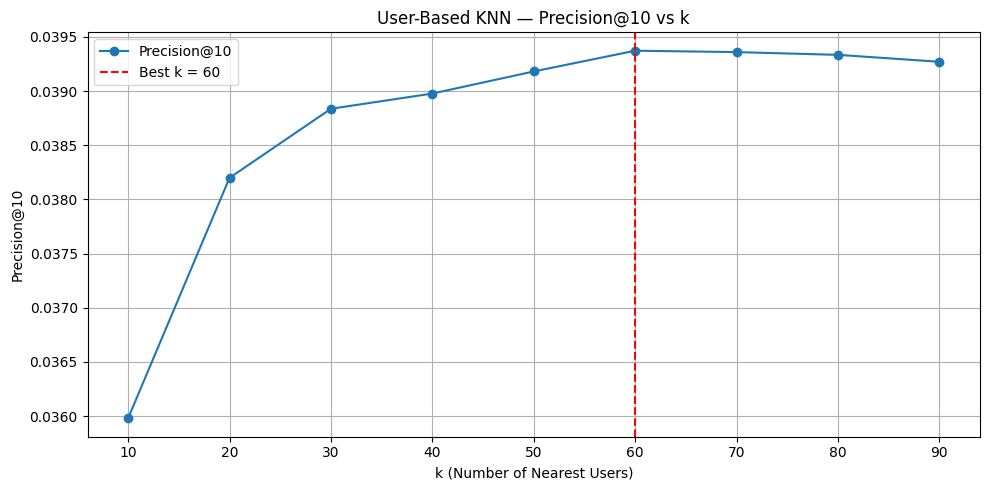

 Best k = 60 with Precision@10 = 0.0394


In [ ]:
# Efficient user-based KNN prediction (vectorized inner loop)
def user_based_knn_predict_fast(train_matrix, k, test_matrix=None):
    n_users, n_items = train_matrix.shape
    predictions = np.zeros((n_users, n_items))

    # Fit KNN on users
    knn = NearestNeighbors(n_neighbors=k+1, metric='cosine', algorithm='brute')
    knn.fit(train_matrix)

    # Find all neighbors in one shot
    distances, indices = knn.kneighbors(train_matrix)

    # Convert distances to similarities
    sim_matrix = 1 - distances[:, 1:]  # drop self
    sim_matrix_sum = sim_matrix.sum(axis=1, keepdims=True) + 1e-9
    sim_weights = sim_matrix / sim_matrix_sum

    # Get neighbors' ratings
    for user_idx in range(n_users):
        neighbors = indices[user_idx, 1:]  # drop self
        ratings = train_matrix[neighbors]  # shape: (k, n_items)
        predictions[user_idx] = np.dot(sim_weights[user_idx], ratings)

    return predictions

# Test values
k_values = list(range(10, 100, 10))
precision_scores = []

for k in k_values:
    print(f"Evaluating k = {k}")
    preds = user_based_knn_predict_fast(train_data_matrix, k)
    precision, _ = precision_recall_at_k(preds, test_data_matrix, k=10)
    precision_scores.append(precision)

# Find best k
best_index = np.argmax(precision_scores)
best_k = k_values[best_index]
best_score = precision_scores[best_index]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(k_values, precision_scores, '-o', label='Precision@10')
plt.axvline(best_k, linestyle='--', color='red', label=f'Best k = {best_k}')
plt.title("User-Based KNN — Precision@10 vs k")
plt.xlabel("k (Number of Nearest Users)")
plt.ylabel("Precision@10")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f" Best k = {best_k} with Precision@10 = {best_score:.4f}")


In [ ]:
# # With cross-validation
# def evaluate_knn_user_based(k, seed):
#     train_df, test_df = random_split_per_user(interactions, test_size=0.2)
#     train_matrix = create_data_matrix(train_df, n_users, n_items)
#     test_matrix = create_data_matrix(test_df, n_users, n_items)

#     preds = user_based_knn_predict_sparse(train_matrix, k)
#     precision, _ = precision_recall_at_k(preds, test_matrix, k=10)
#     return precision

# # Hyperparameter values and seeds
# k_values = list(range(10, 100, 10))
# seeds = list(range(3))

# # Run evaluations in parallel
# precision_results = {
#     k: Parallel(n_jobs=-1)(delayed(evaluate_knn_user_based)(k, seed) for seed in seeds)
#     for k in k_values
# }

# # Compute averages and std deviations
# avg_precision = [np.mean(precision_results[k]) for k in k_values]
# std_precision = [np.std(precision_results[k]) for k in k_values]

# # Determine best k
# best_index = np.argmax(avg_precision)
# best_k = k_values[best_index]
# best_score = avg_precision[best_index]

# # Plot results
# plt.figure(figsize=(10, 5))
# plt.errorbar(k_values, avg_precision, yerr=std_precision, fmt='-o', capsize=5, label='Mean ± Std Dev')
# plt.axvline(best_k, linestyle='--', color='red', label=f'Best k = {best_k}')
# plt.title(f'User-Based KNN — Precision@10 vs k\n(Averaged over {len(seeds)} random splits)')
# plt.xlabel('k (Number of Nearest Users)')
# plt.ylabel('Precision@10')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print(f"Best k = {best_k} with avg Precision@10 = {best_score:.4f}")
